# Multimodal hierarchical in-context RAG

**Author:** Kobe Indemans (kobe.indemans@student.kuleuven.be)\
**Processed document**: Claude 3 model card (https://www-cdn.anthropic.com/de8ba9b01c9ab7cbabf5c33b80b7bbc618857627/Model_Card_Claude_3.pdf)

## Document parsing

In [2]:
path = "../documents/claude-3/"
file_name = "claude-3-paper.pdf"

In [3]:
from unstructured.partition.pdf import partition_pdf
from unstructured_inference.models.base import get_model
from IPython.display import HTML, display
import requests
from dotenv import load_dotenv
import os

# Function to extract elements from PDF
def extract_pdf_elements(path, fname, doc_parsing_model="yolox_quantized", use_api=True):
    """
    Extract images, tables, and text from a PDF file.
    path: File path
    fname: File name
    doc_parsing_model: Document parsing model to use. Default is "yolox_quantized".
    use_api: Use Unstructured API to extract elements. If False, use open-source library.
    """

    if use_api:
        load_dotenv(override=True)
        unstructured_api_key = os.environ.get("UNSTRUCTURED_API_KEY")
        server_url = "https://api.unstructured.io/general/v0/general"
        headers = {"unstructured-api-key": unstructured_api_key}

        try:
            resp = requests.post(
                server_url,
                files={"files": open(path+fname, "rb")},
                data={
                    "strategy": "hi_res",
                    "extract_images_in_pdf": "true",
                    "extract_image_block_types": '["Image", "Table"]',
                    "extract_image_block_to_payload": "true",
                    "pdf_infer_table_structure": "true",
                },
                headers=headers,
            )
        except Exception as e:
            raise e

        if resp.status_code != 200:
            raise Exception(f"Error: {resp.status_code} - {resp.text}")
        else:
            return resp.json()

    else:
        model_object = get_model(doc_parsing_model)
        print("Document parsing model:", model_object.model_path)
        return partition_pdf(
            filename=path + fname,
            extract_images_in_pdf=True,
            extract_image_block_types=["Image", "Table"],
            extract_image_block_to_payload=True,
            infer_table_structure=True,
            hi_res_model_name=doc_parsing_model,
        )

/Users/kobeindemans/Code/School/Master Thesis/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Helper functions
def display_img_base64(img_base64):
    """Display base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def display_html_table(table_html):
    """Display HTML table"""
    display(HTML(table_html))


def count_types(document_elements: list[dict]):
    """Function to count occurrences of each type"""
    type_counts = {}
    for element in document_elements:
        # Get the type from each element
        element_type = element["type"]
        # Increment the count for this type
        if element_type in type_counts:
            type_counts[element_type] += 1
        else:
            type_counts[element_type] = 1
    return type_counts


def filter_elements_by_type(type: str, document_elements: list[dict]):
    """Filter elements by type"""
    return [e for e in document_elements if e["type"] == type]


def group_elements_by_type(document_elements: list[dict]):
    """Group elements by type. Return a list of elements for each type"""
    types = set([e["type"] for e in document_elements])
    return {t: filter_elements_by_type(t, document_elements) for t in types}

### Extract and save PDF elements or load saved data

In [5]:
import pickle

use_saved_elements = True

if use_saved_elements:
    # Load the extracted elements from the pickle file
    with open("staged-data/extracted-pdf-elements.pkl", "rb") as f:
        pdf_elements = pickle.load(f)
else:
    # Perform PDF document parsing
    pdf_elements = extract_pdf_elements(path, file_name)

    # Save the extracted elements to a pickle file
    with open("staged-data/extracted-pdf-elements.pkl", "wb") as f:
        pickle.dump(pdf_elements, f)

In [6]:
pdf_elements

[{'type': 'Title',
  'element_id': '790f1a425a402e5c5e583a45368acc43',
  'text': 'The Claude 3 Model Family: Opus, Sonnet, Haiku',
  'metadata': {'filetype': 'application/pdf',
   'languages': ['eng'],
   'page_number': 1,
   'filename': 'claude-3-paper.pdf'}},
 {'type': 'Title',
  'element_id': 'b7ff9bfce94f1981fb6a851ae0c56271',
  'text': 'Anthropic',
  'metadata': {'filetype': 'application/pdf',
   'languages': ['eng'],
   'page_number': 1,
   'filename': 'claude-3-paper.pdf'}},
 {'type': 'Title',
  'element_id': 'ebf237f98f05c4390df1cde93629de8d',
  'text': 'Abstract',
  'metadata': {'filetype': 'application/pdf',
   'languages': ['eng'],
   'page_number': 1,
   'filename': 'claude-3-paper.pdf'}},
 {'type': 'NarrativeText',
  'element_id': '446f0405dd24bd4b82697b135a8e5e55',
  'text': 'We introduce Claude 3, a new family of large multimodal models – Claude 3 Opus, our most capable offering, Claude 3 Sonnet, which provides a combination of skills and speed, and Claude 3 Haiku, our f

In [7]:
# Define image and table elements
images = [e for e in pdf_elements if e["type"] == "Image"]
tables = [e for e in pdf_elements if e["type"] == "Table"]

### Show some parsing results

In [8]:
# Overview of extracted labels
dict_of_typed_lists = group_elements_by_type(pdf_elements)
print(dict_of_typed_lists.keys())

dict_keys(['UncategorizedText', 'Table', 'NarrativeText', 'ListItem', 'Footer', 'Formula', 'FigureCaption', 'Image', 'Title'])


In [9]:
# Count of each type
type_counts = count_types(pdf_elements)
print(type_counts)

{'Title': 56, 'NarrativeText': 161, 'Footer': 46, 'ListItem': 93, 'Table': 8, 'UncategorizedText': 2, 'Image': 32, 'FigureCaption': 15, 'Formula': 1}



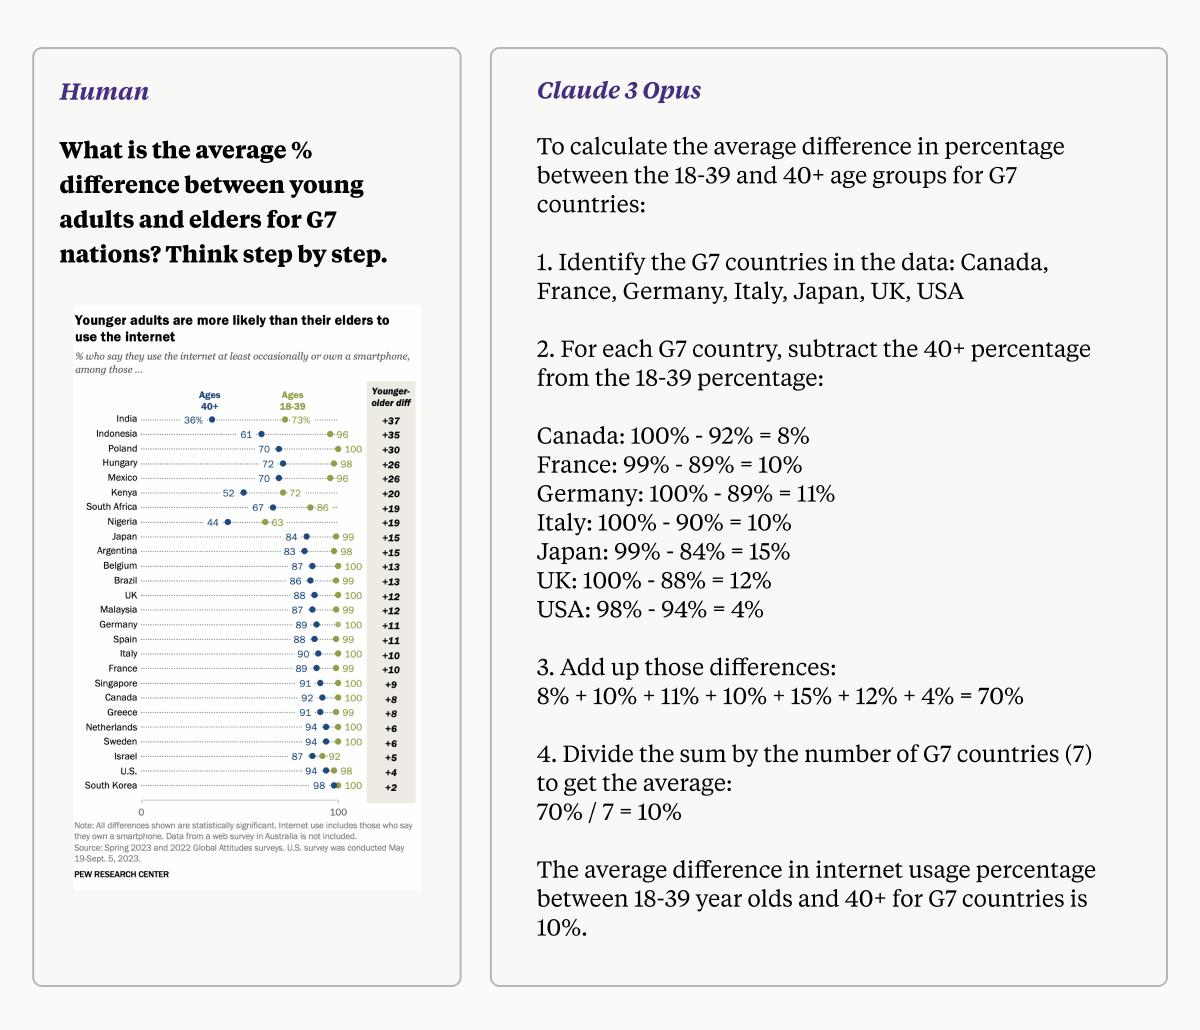

In [10]:
# Display the first image
display_img_base64(images[0]["metadata"]["image_base64"])


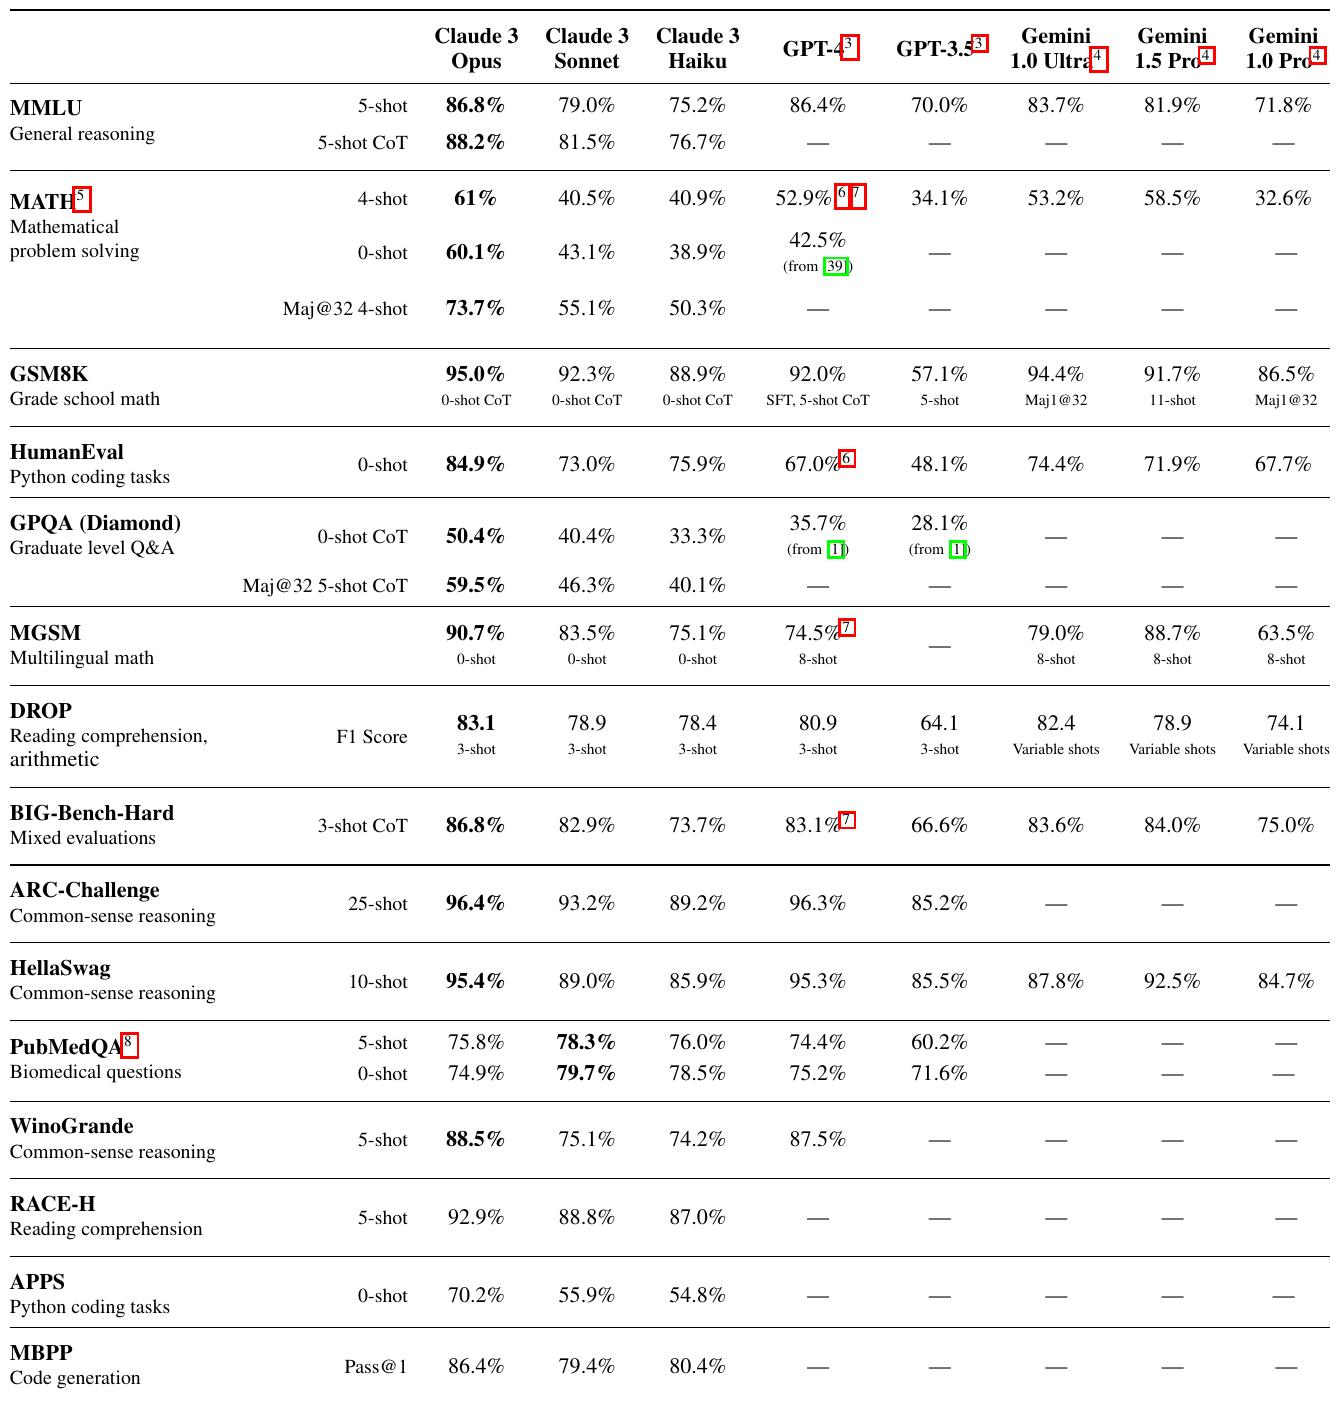

In [11]:
# Display the first table
display_img_base64(tables[0]["metadata"]["image_base64"])

## Process document elements

In [12]:
import os
from dotenv import load_dotenv
from openai import OpenAI, AzureOpenAI

load_dotenv(override=True)

# Set to True if you want to use Azure instead of OpenAI
Azure = True

openai_api_key = os.environ.get("OPENAI_API_KEY")
openai_organization_id = os.environ.get("OPENAI_ORGANIZATION_ID")
azure_openai_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT")
azure_openai_api_key=os.environ.get("AZURE_OPENAI_API_KEY")
azure_openai_api_version=os.environ.get("AZURE_OPENAI_API_VERSION")

openai_client = AzureOpenAI(
    # https://learn.microsoft.com/en-us/azure/ai-services/openai/reference#rest-api-versioning
    api_version=azure_openai_api_version,
    # https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal#create-a-resource
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_api_key,
) if Azure else OpenAI(api_key=openai_api_key, organization=openai_organization_id)

In [13]:
import uuid
import ollama

class DocumentElement:
    def __init__(self, unstructured_element, summary_model="gpt-4-turbo-vision"):
        """Initialize a DocumentElement instance representing a single element extracted from a document."""
        self.id = str(uuid.uuid4())
        self.type = self.simplify_type(unstructured_element)
        self.image = (
            unstructured_element["metadata"]["image_base64"]
            if self.type in ["Image", "Table"]
            else None
        )
        self.summary = (
            self.generate_summary(summary_model)
            if self.type in ["Image", "Table"]
            else None
        )
        self.content = self.transform_content(unstructured_element)
        self.length = self.determine_length()
        self.unstructured_object = unstructured_element

    def simplify_type(self, unstructured_element):
        """Simplify the type of the element to either Image, Table, or Text."""
        if unstructured_element["type"] in ["Image", "Table", "Title"]:
            return unstructured_element["type"]
        else:
            return "Text"

    def generate_summary(self, summary_model):
        if summary_model == "gpt-4-turbo-vision":
            response = openai_client.chat.completions.create(
                model="gpt-4-turbo-vision",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": f"Summarize this {self.type.lower()}. Be concise but include as many key details as possible",
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{self.image}"
                                },
                            },
                        ],
                    }
                ],
                max_tokens=300,
            )
            return response.choices[0].message.content
        elif summary_model == "llava":
            response = ollama.generate(
                summary_model,
                f"Summarize this {self.type.lower()}. Be concise but include as many key details as possible",
                images=[self.image],
            )
            return response["response"]
        else:
            available_models = ["gpt-4-turbo-vision", "llava"]
            raise ValueError(
                f"No valid summary model specified. Please specify one of the available models: {available_models}"
            )

    def transform_content(self, unstructured_element):
        """Transforms image to Markdown image format for images and tables,
        and returns text as is for text elements."""
        if self.type in ["Image", "Table"]:
            return f"![{self.summary}]({self.id})"
        else:
            return unstructured_element["text"]

    def determine_length(self):
        """Assign a length of 0 to the content of images and tables to
        prevent chunking of these elements."""
        if self.type == "Text":
            return len(self.content)
        else:
            return 0

    def to_dict(self):
        """Convert the DocumentElement instance to a dictionary."""
        return {
            "id": self.id,
            "type": self.type,
            "image": self.image,
            "summary": self.summary,
            "content": self.content,
            "length": self.length,
            "unstructured_object": self.unstructured_object,
        }

    @classmethod
    def from_dict(cls, data):
        # Create an instance without calling the original __init__ to avoid side effects like generating new IDs or summaries
        instance = cls.__new__(cls)
        instance.id = data.get("id")
        instance.type = data.get("type")
        instance.image = data.get("image")
        instance.summary = data.get("summary")
        instance.content = data.get("content")
        instance.length = data.get("length")
        instance.unstructured_object = data.get("unstructured_object")
        return instance

### Initialize and save document elements or load saved data
By loading the saved document elements there is no need to regenerate the image summaries.

In [14]:
import json
import os


def load_or_initialize_document_elements(input_data=None, json_file_path="document-elements.json"):
    """Load or initialize DocumentElement objects from input data or a JSON file."""
    if input_data is not None:
        # Initialize new DocumentElement objects from input data
        document_elements = [DocumentElement(e) for e in input_data]
    else:
        # Check if the file exists
        if os.path.exists(json_file_path):
            # Load document elements from the JSON file
            with open(json_file_path, "r") as f:
                documents_dict = json.load(f)
                document_elements = [DocumentElement.from_dict(doc) for doc in documents_dict]
        else:
            raise ValueError("JSON file does not exist.") 

    return document_elements

In [15]:
load_saved_document_elements = True

if load_saved_document_elements:
    document_elements = load_or_initialize_document_elements(
        json_file_path="staged-data/claude3-document-elements.json"
    )
else:
    # Initialize document elements
    document_elements = load_or_initialize_document_elements(input_data=pdf_elements)

    # Serialize to a JSON file
    document_elements_dict = [e.to_dict() for e in document_elements]
    with open("staged-data/claude3-document-elements.json", "w") as f:
        json.dump(document_elements_dict, f)

In [16]:
# Count of each type after processing
new_type_counts = count_types([e.to_dict() for e in document_elements])
print(new_type_counts)

{'Title': 56, 'Text': 318, 'Table': 8, 'Image': 32}


In [17]:
# Print first document element
document_elements[0].to_dict()

{'id': 'e3e96997-f598-47fe-bf08-316885bd37bb',
 'type': 'Title',
 'image': None,
 'summary': None,
 'content': 'The Claude 3 Model Family: Opus, Sonnet, Haiku',
 'length': 0,
 'unstructured_object': {'type': 'Title',
  'element_id': '790f1a425a402e5c5e583a45368acc43',
  'text': 'The Claude 3 Model Family: Opus, Sonnet, Haiku',
  'metadata': {'filetype': 'application/pdf',
   'languages': ['eng'],
   'page_number': 1,
   'filename': 'claude-3-paper.pdf'}}}

In [18]:
text_elements = [e for e in document_elements if e.type in ["Text", "Title"]]
table_elements = [e for e in document_elements if e.type == "Table"]
image_elements = [e for e in document_elements if e.type == "Image"]
len(text_elements), len(table_elements), len(image_elements)

(374, 8, 32)

## Chunking

### Multimodal, context-aware chunking

In [19]:
def multimodal_chunker(elements, string_output=True):
    """Chunking taking into account multiple modalities (text, images, tables) and section titles (context-aware chunking).

    Args:
    elements (list): A list of document elements, where each element could be a text block, image, etc.

    Returns:
    list: A list of chunks, where each chunk is an object containing the element IDs and content of the chunk.
    """

    # Create a list to store the chunks
    chunks = []
    # Temporary list to store elements of the current chunk
    current_chunk = {"id": 0, "element_ids": [], "content": []}
    # Initialize chunk ID
    chunk_id = 0

    # Function to determine if an element is a title
    def is_title(element):
        return element.type == "Title"

    # Iterate over the elements
    for element in elements:
        # Check if the current element is a title
        if is_title(element):
            # If current_chunk is not empty, save it and start a new chunk with incremented ID
            if current_chunk["element_ids"]:
                chunks.append(current_chunk)
                chunk_id += 1
                current_chunk = {"id": chunk_id, "element_ids": [], "content": []}
        # Add the current element's ID to the current chunk
        current_chunk["element_ids"].append(element.id)
        # Add the current element's content to the current chunk
        current_chunk["content"].append(element.content)

    # Add the last chunk if it's not empty
    if current_chunk["element_ids"]:
        chunks.append(current_chunk)

    # Transform the content of each chunk to a single string
    for chunk in chunks:
        chunk["content"] = "\n".join(chunk["content"])

    return chunks if not string_output else [c["content"] for c in chunks]

In [20]:
semantic_chunks = multimodal_chunker(document_elements)

In [21]:
print(*semantic_chunks, sep="\n")

The Claude 3 Model Family: Opus, Sonnet, Haiku
Anthropic
Abstract
We introduce Claude 3, a new family of large multimodal models – Claude 3 Opus, our most capable offering, Claude 3 Sonnet, which provides a combination of skills and speed, and Claude 3 Haiku, our fastest and least expensive model. All new models have vision capabilities that enable them to process and analyze image data. The Claude 3 family demonstrates strong performance across benchmark evaluations and sets a new standard on measures of reasoning, math, and coding. Claude 3 Opus achieves state-of-the-art results on evaluations like GPQA [1], MMLU [2], MMMU [3] and many more. Claude 3 Haiku performs as well or better than Claude 2 [4] on most pure-text tasks, while Sonnet and Opus significantly outperform it. Additionally, these models exhibit improved fluency in non-English languages, making them more versatile for a global audience. In this report, we provide an in-depth analysis of our evaluations, focusing on core

## Tree construction

In [26]:
document_text = "\n\n".join(semantic_chunks)

In [23]:
import tiktoken
import re

tokenizer = tiktoken.get_encoding("cl100k_base")


def split_text_multimodal(
    text: str,
    tokenizer,
    max_tokens: int = 100,
    overlap: int = 0,
):
    """
    Splits the input text into smaller chunks based on the tokenizer and maximum allowed tokens,
    while ensuring that images in markdown syntax are not split and preserving the order of text and images.

    Args:
        text (str): The text to be split.
        tokenizer (CustomTokenizer): The tokenizer to be used for splitting the text.
        max_tokens (int): The maximum allowed tokens.
        overlap (int, optional): The number of overlapping tokens between chunks. Defaults to 0.

    Returns:
        List[str]: A list of text chunks.
    """
    # Define a regex pattern to identify markdown images
    image_pattern = r"!\[.*?\]\(.*?\)"

    # Split the text into parts: images and non-images, keeping track of order
    parts = re.split(f"({image_pattern})", text)

    chunks = []
    current_chunk = []
    current_length = 0

    for part in parts:
        if re.match(image_pattern, part):
            # Handle image part
            image_tokens = len(tokenizer.encode(part))

            if current_length + image_tokens > max_tokens:
                chunks.append("".join(current_chunk).strip())
                current_chunk = current_chunk[-overlap:] if overlap > 0 else []
                current_length = sum(len(tokenizer.encode(p)) for p in current_chunk)

            current_chunk.append(part)
            current_length += image_tokens
        else:
            # Handle text part
            # Split the non-image part into sentences using multiple delimiters
            delimiters = [".", "!", "?", "\n"]
            regex_pattern = "|".join(map(re.escape, delimiters))
            sentences = re.split(regex_pattern, part)

            # Calculate the number of tokens for each sentence
            n_tokens = [len(tokenizer.encode(sentence)) for sentence in sentences]

            for sentence, token_count in zip(sentences, n_tokens):
                # If the sentence is empty or consists only of whitespace, skip it
                if not sentence.strip():
                    continue

                # If the sentence is too long, split it into smaller parts
                if token_count > max_tokens:
                    sub_sentences = re.split(r"[,;:]", sentence)
                    sub_token_counts = [
                        len(tokenizer.encode(sub_sentence))
                        for sub_sentence in sub_sentences
                    ]

                    sub_chunk = []
                    sub_length = 0

                    for sub_sentence, sub_token_count in zip(
                        sub_sentences, sub_token_counts
                    ):
                        if sub_length + sub_token_count > max_tokens:
                            chunks.append("".join(sub_chunk).strip())
                            sub_chunk = sub_chunk[-overlap:] if overlap > 0 else []
                            sub_length = sum(
                                sub_token_counts[
                                    max(0, len(sub_chunk) - overlap) : len(sub_chunk)
                                ]
                            )

                        sub_chunk.append(sub_sentence)
                        sub_length += sub_token_count

                    if sub_chunk:
                        chunks.append("".join(sub_chunk).strip())

                # If adding the sentence to the current chunk exceeds the max tokens, start a new chunk
                elif current_length + token_count > max_tokens:
                    chunks.append("".join(current_chunk).strip())
                    current_chunk = current_chunk[-overlap:] if overlap > 0 else []
                    current_length = sum(
                        n_tokens[
                            max(0, len(current_chunk) - overlap) : len(current_chunk)
                        ]
                    )
                    current_chunk.append(sentence)
                    current_length += token_count

                # Otherwise, add the sentence to the current chunk
                else:
                    current_chunk.append(sentence)
                    current_length += token_count

    # Add any remaining text to the final chunk
    if current_chunk:
        chunks.append("".join(current_chunk).strip())

    return chunks


# Example usage
text = "Here is some text with an image ![alt text](image_url) in the middle."
chunks = split_text_multimodal(text, tokenizer, max_tokens=10, overlap=0)
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk}")

Chunk 1: Here is some text with an image
Chunk 2: ![alt text](image_url) in the middle


In [24]:
class TreeNode:
    def __init__(self, value, level, parent=None):
        self.value = value
        self.children = []
        self.parent = parent
        self.level = level

    def add_child(self, child_node):
        child_node.parent = self
        self.children.append(child_node)

    def to_dict(self):
        return {
            "value": self.value,
            "children": [child.to_dict() for child in self.children],
            "parent": self.parent if self.parent else None,
            "level": self.level,
        }

    def __repr__(self, level=0):
        ret = "\t" * level + repr(self.value) + "\n"
        for child in self.children:
            ret += child.__repr__(level + 1)
        return ret


def build_tree(document, sections):
    # Create the root node with the entire document text
    root = TreeNode(document, level=0)

    for section in sections:
        # Create a node for each section
        section_node = TreeNode(section, level=1, parent=root)
        # Split the section into sentences
        sentences = split_text_multimodal(section, tokenizer, max_tokens=100, overlap=0)
        for sentence in sentences:
            # Create a node for each sentence and add it as a child to the section node
            sentence_node = TreeNode(sentence, level=2, parent=section_node)
            section_node.add_child(sentence_node)
        # Add the section node as a child to the root node
        root.add_child(section_node)

    return root

In [27]:
tree = build_tree(document_text, semantic_chunks)

In [28]:
print(tree)

'The Claude 3 Model Family: Opus, Sonnet, Haiku\n\nAnthropic\n\nAbstract\nWe introduce Claude 3, a new family of large multimodal models – Claude 3 Opus, our most capable offering, Claude 3 Sonnet, which provides a combination of skills and speed, and Claude 3 Haiku, our fastest and least expensive model. All new models have vision capabilities that enable them to process and analyze image data. The Claude 3 family demonstrates strong performance across benchmark evaluations and sets a new standard on measures of reasoning, math, and coding. Claude 3 Opus achieves state-of-the-art results on evaluations like GPQA [1], MMLU [2], MMMU [3] and many more. Claude 3 Haiku performs as well or better than Claude 2 [4] on most pure-text tasks, while Sonnet and Opus significantly outperform it. Additionally, these models exhibit improved fluency in non-English languages, making them more versatile for a global audience. In this report, we provide an in-depth analysis of our evaluations, focusing

In [30]:
level1Nodes = [node for node in tree.children]
level2Nodes = [child for node in level1Nodes for child in node.children]
level2Nodes[0].value

'The Claude 3 Model Family: Opus, Sonnet, Haiku'

## Indexing and retrieval

### Index

In [31]:
import weaviate
import weaviate.classes.config as wc
import os

client = weaviate.connect_to_embedded(
    version="latest",
    headers={
        "X-Azure-Api-Key": os.getenv("AZURE_OPENAI_API_KEY"),
        "X-OpenAI-Api-Key": os.getenv("OPENAI_API_KEY"),
        "X-OpenAI-Organization": os.getenv("OPENAI_ORGANIZATION_ID"),
    },
)

Started /Users/kobeindemans/.cache/weaviate-embedded: process ID 25949


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-06-06T11:26:25+02:00"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-06-06T11:26:25+02:00"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-06-06T11:26:25+02:00"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-06-06T11:26:25+02:00"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2024-06-06T11:26:25+02:00"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://12

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:6a79ea07-66de-4b3d-a672-37434343f1cf Type:INIT Version:1.24.11 Modules:generative-openai,qna-openai,ref2vec-centroid,reranker-cohere,text2vec-cohere,text2vec-huggingface,text2vec-openai NumObjects:0 OS:darwin Arch:arm64}","time":"2024-06-06T11:26:25+02:00"}
{"level":"info","msg":"Completed loading shard docs_VFW9aJ9gHCjP in 7.509833ms","time":"2024-06-06T11:26:26+02:00"}
{"level":"info","msg":"Completed loading shard leafs_9BvzAtA9zraQ in 8.069ms","time":"2024-06-06T11:26:26+02:00"}
{"action":"hnsw_vector_cache_prefill","count":3000,"index_id":"vectors_original_chunk","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-06-06T11:26:26+02:00","took":3167000}
{"action":"hnsw_vector_cache_prefill","count":3000,"index_id":"vectors_leaf_content","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-06-06T11:26:26+02:00","took":12463667}


In [41]:
if client.collections.exists("Leafs"):
    client.collections.delete("Leafs")
leafs = client.collections.create(
    name="Leafs",
    properties=[
        wc.Property(
            name="parent",
            data_type=wc.DataType.TEXT,
            vectorize_property_name=False,
        ),
        wc.Property(
            name="leaf_content",
            data_type=wc.DataType.TEXT,
            vectorize_property_name=False,
        ),
    ],
    vectorizer_config=[
        wc.Configure.NamedVectors.text2vec_azure_openai(
            name="leaf_content",
            source_properties=["leaf_content"],
            resource_name="text-embedding-ada-002",
            deployment_id="text-embedding-ada-002",
            base_url=azure_openai_endpoint,
        ),
    ],
)

{"level":"info","msg":"Created shard leafs_JrUafYPtUzGS in 1.365166ms","time":"2024-06-06T11:33:45+02:00"}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"vectors_leaf_content","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-06-06T11:33:45+02:00","took":52458}


In [42]:
leafs.config.get()

_CollectionConfig(name='Leafs', description=None, generative_config=None, inverted_index_config=_InvertedIndexConfig(bm25=_BM25Config(b=0.75, k1=1.2), cleanup_interval_seconds=60, index_null_state=False, index_property_length=False, index_timestamps=False, stopwords=_StopwordsConfig(preset=<StopwordsPreset.EN: 'en'>, additions=None, removals=None)), multi_tenancy_config=_MultiTenancyConfig(enabled=False), properties=[_Property(name='parent', description=None, data_type=<DataType.TEXT: 'text'>, index_filterable=True, index_searchable=True, nested_properties=None, tokenization=<Tokenization.WORD: 'word'>, vectorizer_config=None, vectorizer='none'), _Property(name='leaf_content', description=None, data_type=<DataType.TEXT: 'text'>, index_filterable=True, index_searchable=True, nested_properties=None, tokenization=<Tokenization.WORD: 'word'>, vectorizer_config=None, vectorizer='none')], references=[], replication_config=_ReplicationConfig(factor=1), reranker_config=None, sharding_config=_S

In [43]:
leaf_objs = [
    {"parent": node.parent.value if node.parent else None, "leaf_content": node.value}
    for node in level2Nodes
]
print(leaf_objs)
print(len(leaf_objs))

[{'parent': 'The Claude 3 Model Family: Opus, Sonnet, Haiku', 'leaf_content': 'The Claude 3 Model Family: Opus, Sonnet, Haiku'}, {'parent': 'Anthropic', 'leaf_content': 'Anthropic'}, {'parent': 'Abstract\nWe introduce Claude 3, a new family of large multimodal models – Claude 3 Opus, our most capable offering, Claude 3 Sonnet, which provides a combination of skills and speed, and Claude 3 Haiku, our fastest and least expensive model. All new models have vision capabilities that enable them to process and analyze image data. The Claude 3 family demonstrates strong performance across benchmark evaluations and sets a new standard on measures of reasoning, math, and coding. Claude 3 Opus achieves state-of-the-art results on evaluations like GPQA [1], MMLU [2], MMMU [3] and many more. Claude 3 Haiku performs as well or better than Claude 2 [4] on most pure-text tasks, while Sonnet and Opus significantly outperform it. Additionally, these models exhibit improved fluency in non-English langua

In [44]:
import time


def split_list(lst, n):
    """Splits the list `lst` into `n` equal parts (as equal as possible)."""
    k, m = divmod(len(lst), n)
    return (lst[i * k + min(i, m) : (i + 1) * k + min(i + 1, m)] for i in range(n))


leaf_objs_length = len(leaf_objs)
num_parts = 4 

# Split the list into `num_parts` parts (needed to avoid embedded Weaviate insertion limits)
leaf_objs_parts = list(split_list(leaf_objs, num_parts))

leafs = client.collections.get("Leafs")

# Insert each part into the collection
for part in leaf_objs_parts:
    leafs.data.insert_many(part)
    time.sleep(10)  # Add a 10-second delay between each insertion to avoid OpenAPI rate limitting issues

In [45]:
count = 0
for item in leafs.iterator():
    count += 1
    if count > 100000:
        break
print(count)

323


In [46]:
import weaviate.classes.query as wq

leafs = client.collections.get("Leafs")
response = leafs.query.near_text(
    query="How does Claude 3's performance on MathVista compare to DocVQA?",
    include_vector="True",
    target_vector="leaf_content",
    return_metadata=wq.MetadataQuery(distance=True),
    return_properties=["leaf_content", "parent"],
    limit=3,
)

In [47]:
# Use a dictionary to store results with unique parents
unique_parent_results = {}
final_results = []

for r in response.objects:
    parent = r.properties.get("parent")
    if parent not in unique_parent_results:
        unique_parent_results[parent] = r
        final_results.append(r)
    # Stop when we have 3 unique parents
    if len(final_results) == 3:
        break

# Print the filtered results
for r in final_results:
    print(r.properties)
    print(f"Distance to query: {r.metadata.distance:.3f}\n")

{'parent': '5.6 Multilingual\nAs we expand access to our technology on a global scale [60], it is important to develop and evaluate large language models on their multilingual capabilities. Our Claude.ai platform was made available in 95 countries last year, and the Claude API’s general availability was extended to 159 countries.\nWe evaluated Claude 3 models on multilingual benchmarks for mathematical and general reasoning capabili- ties. Notably, Claude 3 Opus reaches the state of the art in Multilingual Math MGSM benchmark with a score above 90% in a 0-shot setting. Human feedback review also demonstrated clear improvement in Claude 3 Sonnet, an increase from Claude 2.1 by 9 points as seen in Fig 6.', 'leaf_content': 'Notably, Claude 3 Opus reaches the state of the art in Multilingual Math MGSM benchmark with a score above 90% in a 0-shot setting Human feedback review also demonstrated clear improvement in Claude 3 Sonnet, an increase from Claude 21 by 9 points as seen in Fig 6'}
Di

In [ ]:
# client.close()

## Evaluation

In [49]:
# Create a mapping between image and table elements ids and their base64 representations
def create_id_to_base64_mapping(elements: list[DocumentElement]):
    return {e.id: e.image for e in elements if e.type in ["Image", "Table"]}


id_to_base64_map = create_id_to_base64_mapping(document_elements)
base64_to_id_map = {v: k for k, v in id_to_base64_map.items()}

In [50]:
import json

test_set = open("../documents/claude-3/test-set.json")
test_set_json = json.load(test_set)

img_map = open("../documents/claude-3/img-map.json")
img_map_json = json.load(img_map)

In [51]:
import re
import base64
import io
import os
import imagehash
from PIL import Image
import weaviate
import weaviate.classes.query as wq


def get_image_ids_from_doc(doc):
    img_pattern = re.compile(r"!\[((?:.|\n)*?)\]\(((?:.|\n)*?)\)", re.DOTALL)
    matches = img_pattern.finditer(doc)
    retrieved_img_ids = []
    for match in matches:
        _, img_id = match.groups()
        retrieved_img_ids.append(img_id)
    return retrieved_img_ids


def is_same_image(base64_stringA, base64_stringB):
    def base64_to_image(base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data))
        return image

    imageA = base64_to_image(base64_stringA)
    imageB = base64_to_image(base64_stringB)

    hash1 = imagehash.average_hash(imageA)
    hash2 = imagehash.average_hash(imageB)

    difference = hash1 - hash2
    return difference <= 10


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def evaluate_retriever(
    test_set,
    img_map_test_set,
    img_map_doc_elements=None,
    export_html=False,
    html_file_name="evaluation_results.html",
    mixed_modalities=False,
    weaviate_target_vector="chunk_summary",
    hybrid_search=False,
    limit=3,
):
    scores_per_modality = {}
    html_rows = []

    client = weaviate.connect_to_local(
        headers={"X-Azure-Api-Key": os.getenv("AZURE_OPENAI_API_KEY")},
        port=8079,
        grpc_port=50050,
    )
    docs = client.collections.get("Leafs")

    for example in test_set:
        query = example["question"]
        context = example["context"]
        modality = example["modality"]

        if modality not in scores_per_modality:
            scores_per_modality[modality] = {"correct": 0, "total": 0}

        if hybrid_search:
            response = docs.query.hybrid(
                query=query,
                include_vector="True",
                target_vector=weaviate_target_vector,
                return_metadata=wq.MetadataQuery(distance=True),
                return_properties=["leaf_content", "parent"],
                limit=limit,
            )
        else:
            response = docs.query.near_text(
                query=query,
                include_vector="True",
                target_vector=weaviate_target_vector,
                return_metadata=wq.MetadataQuery(distance=True),
                return_properties=["leaf_content", "parent"],
                limit=limit * 4,
            )
        # Use a dictionary to store results with unique parents
        unique_parent_results = {}
        final_results = []

        for r in response.objects:
            parent = r.properties.get("parent")
            if parent not in unique_parent_results:
                unique_parent_results[parent] = r
                final_results.append(r)
            # Stop when we have [limit] unique parents
            if len(final_results) == limit:
                break
        retrieved_docs = [r.properties["parent"] for r in final_results]

        is_correct = False

        if modality in ["image", "table"]:
            expected_image = img_map_test_set[context]
            for doc in retrieved_docs:
                if mixed_modalities:
                    retrieved_img_ids = get_image_ids_from_doc(doc)
                    retrieved_images = [
                        img_map_doc_elements[img_id] for img_id in retrieved_img_ids
                    ]
                    for retrieved_image in retrieved_images:
                        if is_same_image(expected_image, retrieved_image):
                            scores_per_modality[modality]["correct"] += 1
                            is_correct = True
                            break
                    if is_correct:
                        break
                else:
                    if (
                        looks_like_base64(doc)
                        and is_image_data(doc)
                        and is_same_image(expected_image, doc)
                    ):
                        scores_per_modality[modality]["correct"] += 1
                        is_correct = True
                        break

        else:
            for doc in retrieved_docs:
                if context in doc:
                    scores_per_modality[modality]["correct"] += 1
                    is_correct = True
                    break

        scores_per_modality[modality]["total"] += 1

        # Prepare HTML row for this example
        retrieved_context = "<br><br>".join(retrieved_docs)
        html_rows.append(
            f"<tr><td>{modality}</td><td>{query}</td><td>{context}</td><td>{retrieved_context}</td><td>{'Yes' if is_correct else 'No'}</td></tr>"
        )

    correct = sum([score["correct"] for score in scores_per_modality.values()])
    total = sum([score["total"] for score in scores_per_modality.values()])

    # Generate and export HTML if required
    if export_html:
        html_content = f"""<html>
                        <head><title>Evaluation Results</title></head>
                        <body>
                        <h1>{html_file_name}</h1>
                        <p>Score: {correct / total}</p>
                        <p>Score per modality: {scores_per_modality}</p>
                        <table border="1">
                        <tr><th>Modality</th><th>Question</th><th>Needed Context</th><th>Retrieved Context</th><th>Correct?</th></tr>
                        {''.join(html_rows)}
                        </table>
                        </body>
                        </html>"""

        with open(html_file_name, "w") as html_file:
            html_file.write(html_content)

    return {
        "score": correct / total,
        "correct": correct,
        "total": total,
        "scores_per_modality": scores_per_modality,
    }

In [52]:
evaluate_retriever(
    test_set=test_set_json,
    img_map_test_set=img_map_json,
    img_map_doc_elements=id_to_base64_map,
    export_html=True,
    html_file_name="results/multimodal-hierarchical-in-context-rag.html",
    mixed_modalities=True,
    weaviate_target_vector="leaf_content",
    hybrid_search=False,
    limit=3,
)

/var/folders/2_/h2kzt1b55_x1w2x71mvpcx440000gn/T/ipykernel_20882/21470598.py:1: ResourceWarning: unclosed <socket.socket fd=99, family=2, type=1, proto=6, laddr=('127.0.0.1', 58608), raddr=('127.0.0.1', 8079)>
  evaluate_retriever(


{'score': 1.0,
 'correct': 40,
 'total': 40,
 'scores_per_modality': {'text': {'correct': 20, 'total': 20},
  'table': {'correct': 10, 'total': 10},
  'image': {'correct': 10, 'total': 10}}}